### Customer Segmentation
* Scope: The goal of this project is to make a segmentation of prospect customers on new markets.
* Kaggle project: https://www.kaggle.com/datasets/vetrirah/customer

In [213]:
try:
    from IPython import get_ipython
    get_ipython().magic('clear')
    get_ipython().magic('reset -f')
except:
    pass

## 1. Import Libraries

In [451]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from fast_ml.feature_selection import get_duplicate_features
pd.pandas.set_option('display.max_columns', None)
import os
import pathlib
import datetime
from dateutil.relativedelta import relativedelta
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import itertools
from scipy.stats import chi2_contingency
from itertools import product
import scipy.stats as ss
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import pickle
import sys 
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings("ignore")

## 2. Functions

In [215]:
# Call functions
sys.path.insert(1, '/Users/macbookpro/Desktop/PYTHON/1. PROJECTS/Help_files/')

from Functions import compute_vif, calc_outliers_df, calc_outliers_var, distribution, corr_cat, box_plot, distplot, histplot

## 3. Gathering Data

In [216]:
# Import training dataset
df1 = pd.read_csv(r'/Users/macbookpro/Desktop/PYTHON/1. PROJECTS/2. Customer Segmentation/2. Data/Train.csv')
print('Shape of the dataset: ', df1.shape)

Shape of the dataset:  (8068, 11)


In [217]:
# Test dataset
df2 = pd.read_csv(r'/Users/macbookpro/Desktop/PYTHON/1. PROJECTS/2. Customer Segmentation/2. Data/Test.csv')
print('Shape of the dataset: ', df2.shape)

Shape of the dataset:  (2627, 10)


In [350]:
# Copy datasets
train = df1.copy()
test = df2.copy()

## 4. Exploratory Data Analysis

In [351]:
# Inspect the train dataset
print('Shape of the dataset: ', train.shape)
train.head()

Shape of the dataset:  (8068, 11)


,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


### 4.1 Univariate analysis
#### 4.1.1 Distribution of values
Notes:
1. We have unique ids - prospect customers
2. Men are 10pp more than women (55% vs 45%)
3. Approximately 60% of prospect customers are married
4. Age variable has a positive skewness  and the median age is about 40 years old
5. More than 60% of prospect customers are graduated
6. There are 9 different professions and about 1/3 of prospect customers are considerated as artists
7. About 60% of prospect customers have only 0 to 1 years of experience. Half of them have no any experience
8. The majority of prospect customers ~85% have a low and medium spending score. A big part of them about 60% have low spending score
9. About 20% have no other family member and another 30% have only one family member
10. Segmentations are spread equally 

In [352]:
# 1. Id - Check if we have unique ids
print('There are unique IDs in the dataset: ', train['ID'].nunique() == train.shape[0])

There are unique IDs in the dataset:  True


In [353]:
# 2. Gender - Distribution of genders on the dataset
display(train['Gender'].value_counts(dropna=False))
display(round(train['Gender'].value_counts(dropna=False, normalize=True)*100,1))

Male      4417
Female    3651
Name: Gender, dtype: int64

Male      54.7
Female    45.3
Name: Gender, dtype: float64

In [354]:
# 3. Married - Distribution of married status on the dataset
display(train['Ever_Married'].value_counts(dropna=False))
display(round(train['Ever_Married'].value_counts(dropna=False, normalize=True)*100,1))

Yes    4643
No     3285
NaN     140
Name: Ever_Married, dtype: int64

Yes    57.5
No     40.7
NaN     1.7
Name: Ever_Married, dtype: float64

Skewness of the Age is : 0.696020586305935


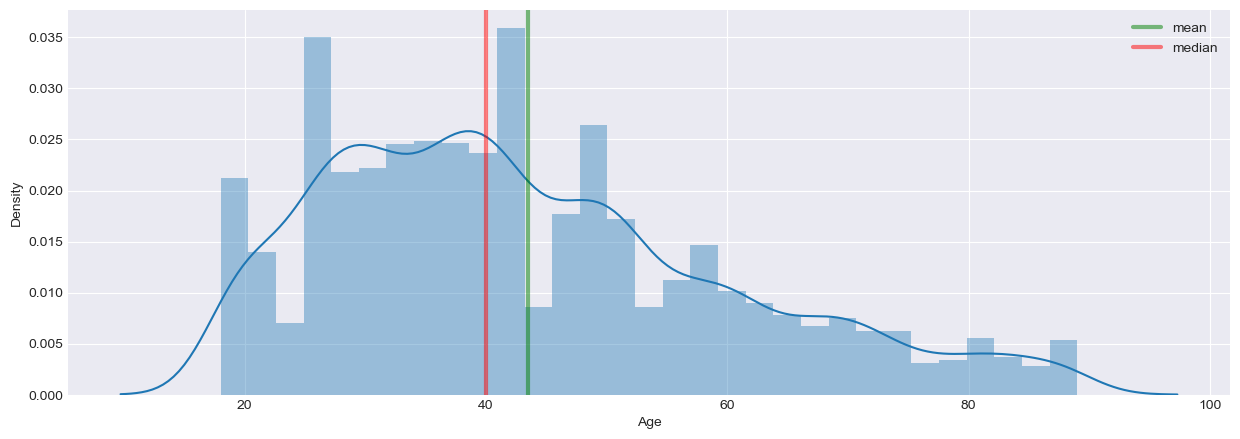

In [355]:
# 4. Age - Distribution of age
distplot(train, 'Age')

In [356]:
# 5. Graduated - Distribution of graduation status on the dataset
display(train['Graduated'].value_counts(dropna=False))
display(round(train['Graduated'].value_counts(dropna=False, normalize=True)*100,1))

Yes    4968
No     3022
NaN      78
Name: Graduated, dtype: int64

Yes    61.6
No     37.5
NaN     1.0
Name: Graduated, dtype: float64

In [357]:
# 6. Profession - Distribution of professions on the dataset
display(train['Profession'].value_counts(dropna=False))
display(round(train['Profession'].value_counts(dropna=False, normalize=True)*100,1))

Artist           2516
Healthcare       1332
Entertainment     949
Engineer          699
Doctor            688
Lawyer            623
Executive         599
Marketing         292
Homemaker         246
NaN               124
Name: Profession, dtype: int64

Artist           31.2
Healthcare       16.5
Entertainment    11.8
Engineer          8.7
Doctor            8.5
Lawyer            7.7
Executive         7.4
Marketing         3.6
Homemaker         3.0
NaN               1.5
Name: Profession, dtype: float64

In [358]:
# 7. Work_Experience - Distribution of Work_Experiences on the dataset
display(train['Work_Experience'].value_counts(dropna=False).sort_index())
display(round(train['Work_Experience'].value_counts(dropna=False, normalize=True)*100,1).sort_index())

0.0     2318
1.0     2354
2.0      286
3.0      255
4.0      253
5.0      194
6.0      204
7.0      196
8.0      463
9.0      474
10.0      53
11.0      50
12.0      48
13.0      46
14.0      45
NaN      829
Name: Work_Experience, dtype: int64

0.0     28.7
1.0     29.2
2.0      3.5
3.0      3.2
4.0      3.1
5.0      2.4
6.0      2.5
7.0      2.4
8.0      5.7
9.0      5.9
10.0     0.7
11.0     0.6
12.0     0.6
13.0     0.6
14.0     0.6
NaN     10.3
Name: Work_Experience, dtype: float64

In [359]:
# 8. Spending_Score - Distribution of Spending_Scores on the dataset
display(train['Spending_Score'].value_counts(dropna=False).sort_index())
display(round(train['Spending_Score'].value_counts(dropna=False, normalize=True)*100,1).sort_index())

Average    1974
High       1216
Low        4878
Name: Spending_Score, dtype: int64

Average    24.5
High       15.1
Low        60.5
Name: Spending_Score, dtype: float64

In [360]:
# 9. Family_Size - Distribution of Family_Sizes on the dataset
display(train['Family_Size'].value_counts(dropna=False).sort_index())
display(round(train['Family_Size'].value_counts(dropna=False, normalize=True)*100,1).sort_index())

1.0    1453
2.0    2390
3.0    1497
4.0    1379
5.0     612
6.0     212
7.0      96
8.0      50
9.0      44
NaN     335
Name: Family_Size, dtype: int64

1.0    18.0
2.0    29.6
3.0    18.6
4.0    17.1
5.0     7.6
6.0     2.6
7.0     1.2
8.0     0.6
9.0     0.5
NaN     4.2
Name: Family_Size, dtype: float64

Skewness of the Family_Size is : 1.010804210772843


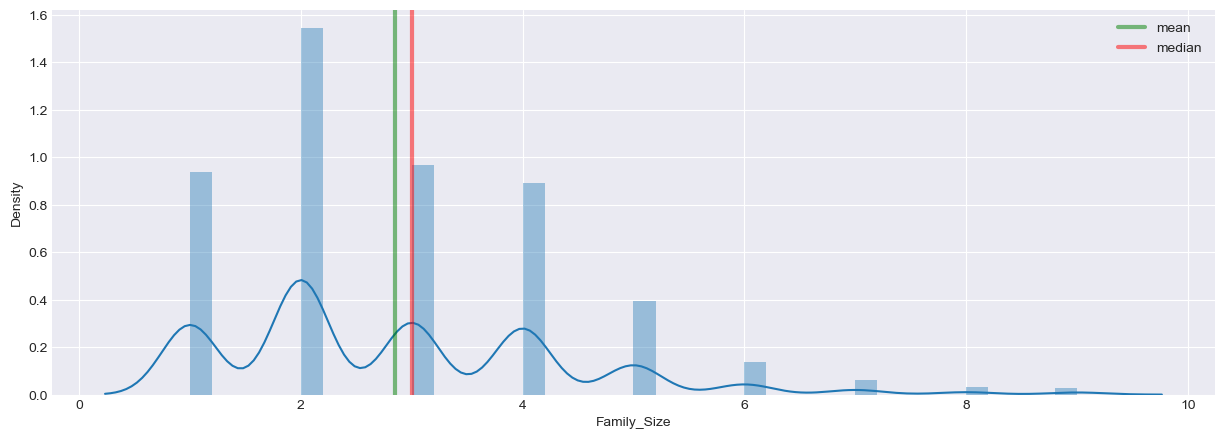

In [361]:
distplot(train, 'Family_Size')

In [362]:
# 10. Var_1 - Distribution of Var_1s on the dataset
display(train['Var_1'].value_counts(dropna=False).sort_index())
display(round(train['Var_1'].value_counts(dropna=False, normalize=True)*100,1).sort_index())

Cat_1     133
Cat_2     422
Cat_3     822
Cat_4    1089
Cat_5      85
Cat_6    5238
Cat_7     203
NaN        76
Name: Var_1, dtype: int64

Cat_1     1.6
Cat_2     5.2
Cat_3    10.2
Cat_4    13.5
Cat_5     1.1
Cat_6    64.9
Cat_7     2.5
NaN       0.9
Name: Var_1, dtype: float64

In [363]:
# 11. Segmentation - Distribution of Segmentations on the dataset
display(train['Segmentation'].value_counts(dropna=False).sort_index())
display(round(train['Segmentation'].value_counts(dropna=False, normalize=True)*100,1).sort_index())

A    1972
B    1858
C    1970
D    2268
Name: Segmentation, dtype: int64

A    24.4
B    23.0
C    24.4
D    28.1
Name: Segmentation, dtype: float64

#### 4.1.2 Null values 
The percentage of missing values is not as high as we can safely remove variables

In [364]:
# Create in dataframe format the prc of missing values 
prc_missing_1 = train.isnull().sum()*100/len(train)
prc_missing_1_df = pd.DataFrame(prc_missing_1, columns=['Missing values'])
prc_missing_1_df.index.name = 'Features'
prc_missing_1_df = prc_missing_1_df.reset_index()
prc_missing_1_df = prc_missing_1_df.loc[prc_missing_1_df['Missing values'] != 0].sort_values('Missing values', ascending=False)
display(prc_missing_1_df)

# Check data type
print('\n','Data Type')
prc_missing_1_df_col = prc_missing_1_df['Features'].to_list()
display(train[prc_missing_1_df_col].dtypes)

,Features,Missing values
6,Work_Experience,10.275161
8,Family_Size,4.152206
2,Ever_Married,1.735250
5,Profession,1.536936
4,Graduated,0.966782
9,Var_1,0.941993



 Data Type


Work_Experience    float64
Family_Size        float64
Ever_Married        object
Profession          object
Graduated           object
Var_1               object
dtype: object

#### 4.1.3 Data type

In [365]:
train.dtypes.sort_values()

ID                   int64
Age                  int64
Work_Experience    float64
Family_Size        float64
Gender              object
Ever_Married        object
Graduated           object
Profession          object
Spending_Score      object
Var_1               object
Segmentation        object
dtype: object

#### 4.1.4 Outliers
* It seems that there are some outliers in both variables. Also, the variables work experience and family size both have missing values, as well as it is shown in the box plots below there is right skewness
* Regarding family size, outliers correspond to about 1% of total size of the dataset
* Regarding work experience the outliers correspond to about 2,4% of total size of the dataset

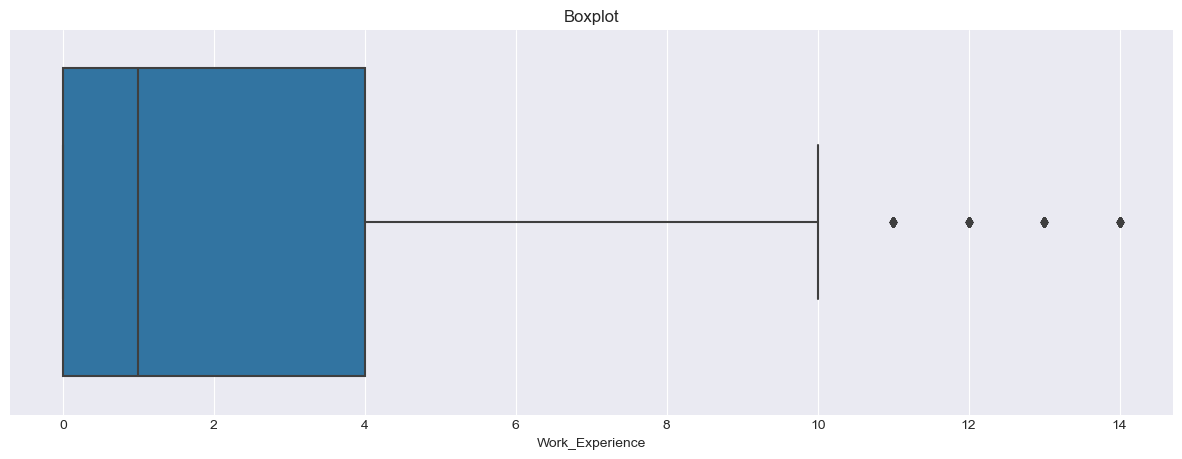

In [366]:
# 1. Working experience - outliers
box_plot(train, 'Work_Experience')

In [367]:
# 1.1 Working experience - number of outliers
train.loc[train['Work_Experience'] > 10]['Work_Experience'].value_counts()

11.0    50
12.0    48
13.0    46
14.0    45
Name: Work_Experience, dtype: int64

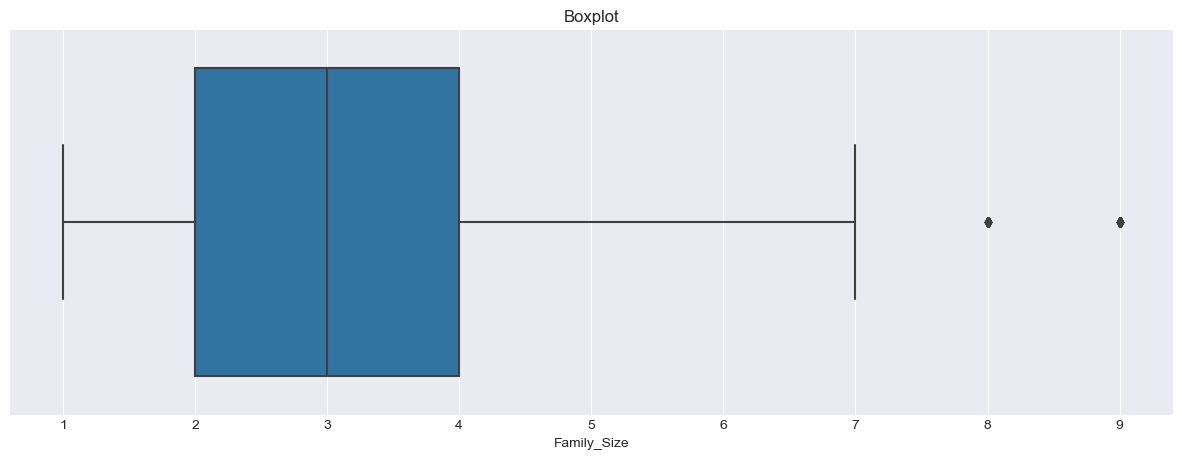

In [368]:
# 2. Family size
box_plot(train, 'Family_Size')

In [369]:
# 1.1 Family size - number of outliers
train.loc[train['Family_Size'] > 7]['Family_Size'].value_counts()

8.0    50
9.0    44
Name: Family_Size, dtype: int64

#### 4.1.5 Duplicates
There are no duplicate IDs in the train dataset

In [370]:
# Check for duplicates
train.loc[train.duplicated(subset='ID')]

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation


### 4.2 Multivariate analysis
#### 4.2.1 Correlation between numeric variables
* Initially, we will check the correlation between variables
* Generally we want to have high correlation between the targeted variable and the rest variables
* On the other hand, we want to have low correlation among independet variables. If the correlation among them is high we can safely remove some of them
* High correlation between independet variables leads to multi collinearity problems
* Size of correlation
    - 1-3 -> small correlation
    - 3-5 -> medium correlation
    - 5-10 -> large correlation


Notes:
* There is a weak negative relationship between Age and Work Experience (-0.19)
* There is a moderate negative relationship between Age and Family Size (-0.28)
* The correlation between Work Experience and Family Size is also weak and negative (-0.06)

In [371]:
# Check correlation among variables
corr = train.corr()
corr

,ID,Age,Work_Experience,Family_Size
ID,1.000000,-0.005055,-0.030688,0.011801
Age,-0.005055,1.000000,-0.190789,-0.280517
Work_Experience,-0.030688,-0.190789,1.000000,-0.063234
Family_Size,0.011801,-0.280517,-0.063234,1.000000


#### 4.2.2 Analysis of targeted variable with the in independed variables
1. Men are approximately 10pp higher than women (55% vs 45%), it seems that men and women are spread equally on all segments
2. The median age is 40. Segments A, B and C are close to the median age. Segment D is about 28% less than the median age
3. For segments A, B and C the percentage of married customers is higher that the percentage of non maried customers. More specifically, for segments B and C about 3/4 are married vs non married and for segment A, more than half of customers are married too. For segment D, it seems that only 1/4 of prospect customers are married vs non married. It can be easily explained due to the fact that in that segment as we saw earlier the median age is 29 years old conpared to the other segments that the median age is above 40
4. The same view for graduation and segment. For the segments A, B and C the percentage of graduated is much higher than non graduated and for segment D the percentage of non graduated is higher (60% vs 40%)
5. As we saw earlier about 2/3 of prospect customers have 0 to 1 working experience. The median working experience for prospect customers in every segment is the same, 1 year
6. In segments A, B and D the spending score is low 
7. Family size for segments A and B is 2 and for segments C and D is 3
8. In every segment the majority of prospect customers are coming from Anonymised Category 6
10. There is no difference of family sizes on categories of spending scores. In every category score the median family size is 3

* Ever married and family size
    * If the column "Ever_Married", describes the current married status of a prospect customer, the the column "Family_Size", have to be at least 2
    * If the column "Ever_Married", describes if someone has been married in the past, I should create an new column that will describe the current status of every customer
    * The median age for these customers is 58. I suppose that the column "Ever_Married", describe if someone has been married in the past, so I should created an other column with the updated married status of customers

In [372]:
# 1. Analyze targeted variable and gender
gender_perc = train.groupby(['Segmentation'])['Gender'].value_counts(normalize=True).mul(100).round(1).to_frame().rename(columns={'Gender':'Percentage'})
gender_abs = train.groupby(['Segmentation'])['Gender'].value_counts(normalize=False).to_frame().rename(columns={'Gender':'Absolute'})
final_gender = pd.concat([gender_abs, gender_perc], axis=1)
final_gender

Absolute  Percentage
Segmentation Gender                      
A            Male        1063        53.9
             Female       909        46.1
B            Male         997        53.7
             Female       861        46.3
C            Male        1048        53.2
             Female       922        46.8
D            Male        1309        57.7
             Female       959        42.3

In [373]:
# 2. Analyze targeted variable and age
train.groupby('Segmentation')['Age'].median().to_frame().reset_index()

,Segmentation,Age
0,A,41.0
1,B,46.0
2,C,49.0
3,D,29.0


In [374]:
# 3. Analyze targeted variable and Ever_Married
mar_perc = train.groupby(['Segmentation'])['Ever_Married'].value_counts(normalize=True).mul(100).round(1).to_frame().rename(columns={'Ever_Married':'Percentage'})
mar_abs = train.groupby(['Segmentation'])['Ever_Married'].value_counts(normalize=False).to_frame().rename(columns={'Ever_Married':'Absolute'})
final_mar = pd.concat([mar_abs, mar_perc], axis=1)
final_mar

Absolute  Percentage
Segmentation Ever_Married                      
A            Yes               1137        58.7
             No                 801        41.3
B            Yes               1348        73.8
             No                 479        26.2
C            Yes               1549        79.6
             No                 398        20.4
D            No                1607        72.5
             Yes                609        27.5

In [375]:
# 4. Analyze targeted variable and Graduated
grad_perc = train.groupby(['Segmentation'])['Graduated'].value_counts(normalize=True).mul(100).round(1).to_frame().rename(columns={'Graduated':'Percentage'})
grad_abs = train.groupby(['Segmentation'])['Graduated'].value_counts(normalize=False).to_frame().rename(columns={'Graduated':'Absolute'})
final_grad = pd.concat([grad_abs, grad_perc], axis=1)
final_grad

Absolute  Percentage
Segmentation Graduated                      
A            Yes            1219        62.6
             No              729        37.4
B            Yes            1332        72.4
             No              508        27.6
C            Yes            1607        82.2
             No              348        17.8
D            No             1437        64.0
             Yes             810        36.0

In [376]:
# 5. Analyze targeted variable and work experience
train.groupby('Segmentation')['Work_Experience'].median().to_frame().reset_index()

,Segmentation,Work_Experience
0,A,1.0
1,B,1.0
2,C,1.0
3,D,1.0


In [377]:
# 6. Analyze targeted variable and Spending_Score
score_perc = train.groupby(['Segmentation'])['Spending_Score'].value_counts(normalize=True).mul(100).round(1).to_frame().rename(columns={'Spending_Score':'Percentage'})
score_abs = train.groupby(['Segmentation'])['Spending_Score'].value_counts(normalize=False).to_frame().rename(columns={'Spending_Score':'Absolute'})
final_score = pd.concat([score_abs, score_perc], axis=1)
final_score

Absolute  Percentage
Segmentation Spending_Score                      
A            Low                 1358        68.9
             Average              343        17.4
             High                 271        13.7
B            Low                  884        47.6
             Average              590        31.8
             High                 384        20.7
C            Average              903        45.8
             Low                  662        33.6
             High                 405        20.6
D            Low                 1974        87.0
             High                 156         6.9
             Average              138         6.1

In [378]:
# 7. Analyze targeted variable and Family size
train.groupby('Segmentation')['Family_Size'].median().to_frame().reset_index()

,Segmentation,Family_Size
0,A,2.0
1,B,2.0
2,C,3.0
3,D,3.0


In [379]:
# 8. Analyze targeted variable and Var_1
var_perc = train.groupby(['Segmentation'])['Var_1'].value_counts(normalize=True).mul(100).round(1).to_frame().rename(columns={'Var_1':'Percentage'})
var_abs = train.groupby(['Segmentation'])['Var_1'].value_counts(normalize=False).to_frame().rename(columns={'Var_1':'Absolute'})
final_var = pd.concat([var_abs, var_perc], axis=1)
final_var

Absolute  Percentage
Segmentation Var_1                      
A            Cat_6      1213        62.1
             Cat_4       333        17.1
             Cat_3       223        11.4
             Cat_2        83         4.2
             Cat_7        51         2.6
             Cat_1        31         1.6
             Cat_5        19         1.0
B            Cat_6      1232        66.8
             Cat_4       232        12.6
             Cat_3       186        10.1
             Cat_2       106         5.7
             Cat_7        43         2.3
             Cat_1        26         1.4
             Cat_5        20         1.1
C            Cat_6      1496        76.8
             Cat_3       154         7.9
             Cat_4       109         5.6
             Cat_2        99         5.1
             Cat_7        47         2.4
             Cat_1        26         1.3
             Cat_5        18         0.9
D            Cat_6      1297        57.8
             Cat_4       415        18.5
             Cat_3       259        11.5
             Cat_2       134         6.0
             Cat_7        62         2.8
             Cat_1        50         2.2
             Cat_5        28         1.2

In [380]:
# 9. Check the accuracy of the columns married status and family size
# Create a new column to check if Ever_Married and Family_Size are identical
train['Check'] = np.where(((train.Ever_Married == 'Yes') & (train.Family_Size == 1)), 'False','True')
print('The median age of the customers who have status married but the family size is 1, is: ', train.loc[train['Check'] == 'False']['Age'].median())

train.head(2)

The median age of the customers who have status married but the family size is 1, is:  58.0


,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation,Check
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D,True
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A,True


In [381]:
# 10. Analyze the relationship between family size and spending score
pd.pivot_table(data=train, index='Spending_Score', values='Family_Size', aggfunc='median').reset_index()

,Spending_Score,Family_Size
0,Average,3.0
1,High,2.0
2,Low,2.0


#### 4.2.3 Correlation of categorical variables

In [382]:
# Subset of dataset with only categorical varbales
cat_df = train[['Gender','Ever_Married','Graduated','Profession','Spending_Score','Var_1','Segmentation']]
cat_df

,Gender,Ever_Married,Graduated,Profession,Spending_Score,Var_1,Segmentation
0,Male,No,No,Healthcare,Low,Cat_4,D
1,Female,Yes,Yes,Engineer,Average,Cat_4,A
2,Female,Yes,Yes,Engineer,Low,Cat_6,B
3,Male,Yes,Yes,Lawyer,High,Cat_6,B
4,Female,Yes,Yes,Entertainment,High,Cat_6,A
...,...,...,...,...,...,...,...
8063,Male,No,No,NaN,Low,Cat_1,D
8064,Male,No,No,Executive,Low,Cat_4,D
8065,Female,No,Yes,Healthcare,Low,Cat_6,D
8066,Female,No,Yes,Healthcare,Low,Cat_6,B


In [383]:
# Split the dataset into two parts
cat_var_1 = ['Gender','Ever_Married','Graduated','Profession','Spending_Score','Var_1','Segmentation']

cat_var_2 = ['Gender','Ever_Married','Graduated','Profession','Spending_Score','Var_1','Segmentation']

# Create all possible combinations
cat_var_comb = list(itertools.product(cat_var_1, cat_var_2, repeat=1))

print(len(cat_var_comb))
cat_var_comb

49


[('Gender', 'Gender'),
 ('Gender', 'Ever_Married'),
 ('Gender', 'Graduated'),
 ('Gender', 'Profession'),
 ('Gender', 'Spending_Score'),
 ('Gender', 'Var_1'),
 ('Gender', 'Segmentation'),
 ('Ever_Married', 'Gender'),
 ('Ever_Married', 'Ever_Married'),
 ('Ever_Married', 'Graduated'),
 ('Ever_Married', 'Profession'),
 ('Ever_Married', 'Spending_Score'),
 ('Ever_Married', 'Var_1'),
 ('Ever_Married', 'Segmentation'),
 ('Graduated', 'Gender'),
 ('Graduated', 'Ever_Married'),
 ('Graduated', 'Graduated'),
 ('Graduated', 'Profession'),
 ('Graduated', 'Spending_Score'),
 ('Graduated', 'Var_1'),
 ('Graduated', 'Segmentation'),
 ('Profession', 'Gender'),
 ('Profession', 'Ever_Married'),
 ('Profession', 'Graduated'),
 ('Profession', 'Profession'),
 ('Profession', 'Spending_Score'),
 ('Profession', 'Var_1'),
 ('Profession', 'Segmentation'),
 ('Spending_Score', 'Gender'),
 ('Spending_Score', 'Ever_Married'),
 ('Spending_Score', 'Graduated'),
 ('Spending_Score', 'Profession'),
 ('Spending_Score', 'Spe

In [384]:
# Create an empty variable and picking only the p value from the output of chi-square
result = []

for i in cat_var_comb:
    if(i[0] != i[1]):
        result.append((i[0], i[1], list(ss.chi2_contingency(pd.crosstab(
            cat_df[i[0]], cat_df[i[1]]
            )))[1]))

result
# Create a table with the result
chi_2_test = pd.DataFrame(result, columns=['Var1','Var2','Coeff'])

# Create an extra colun to identify if there is relationship between pairs of variables
chi_2_test['Relationship'] = np.where(chi_2_test['Coeff']<=0.05, 1,0)

# Reshape the dataset
chi_2_test_pvt = chi_2_test.pivot(index='Var1', columns='Var2', values='Coeff')

## 5. Feature Engineering
### 5.1.1 Missing Values - Train

In [385]:
# Copy
train1 = train.copy()

In [386]:
# Imputation of categorical variables
train1['Ever_Married'].fillna(train1['Ever_Married'].value_counts(dropna=False).sort_values(ascending=False).index[0], inplace=True) 
train1['Profession'].fillna(train1['Profession'].value_counts(dropna=False).sort_values(ascending=False).index[0], inplace=True) 
train1['Graduated'].fillna(train1['Graduated'].value_counts(dropna=False).sort_values(ascending=False).index[0], inplace=True) 
train1['Var_1'].fillna(train1['Var_1'].value_counts(dropna=False).sort_values(ascending=False).index[0], inplace=True)

# Impute numeric variables
train1['Work_Experience'].fillna(train1['Work_Experience'].median(), inplace=True)
train1['Family_Size'].fillna(train1['Family_Size'].median(), inplace=True)

# Check for null values
train1.isna().sum()

ID                 0
Gender             0
Ever_Married       0
Age                0
Graduated          0
Profession         0
Work_Experience    0
Spending_Score     0
Family_Size        0
Var_1              0
Segmentation       0
Check              0
dtype: int64

### 5.1.2 Missing Values - Test

In [387]:
# Imputation of categorical variables
test['Ever_Married'].fillna(test['Ever_Married'].value_counts(dropna=False).sort_values(ascending=False).index[0], inplace=True) 
test['Profession'].fillna(test['Profession'].value_counts(dropna=False).sort_values(ascending=False).index[0], inplace=True) 
test['Graduated'].fillna(test['Graduated'].value_counts(dropna=False).sort_values(ascending=False).index[0], inplace=True) 
test['Var_1'].fillna(test['Var_1'].value_counts(dropna=False).sort_values(ascending=False).index[0], inplace=True)

# Impute numeric variables
test['Work_Experience'].fillna(test['Work_Experience'].median(), inplace=True)
test['Family_Size'].fillna(test['Family_Size'].median(), inplace=True)

# Check for null values
test.isna().sum()

ID                 0
Gender             0
Ever_Married       0
Age                0
Graduated          0
Profession         0
Work_Experience    0
Spending_Score     0
Family_Size        0
Var_1              0
dtype: int64

### 5.2.1 Outliers - Train

In [393]:
# Replace outliers of the column with the highest band 
train1.loc[train1['Family_Size'] > 7, 'Family_Size'] = 7

# Check 
train1.Family_Size.value_counts(normalize=True).mul(100).round(1).sort_index()

1.0    18.0
2.0    29.6
3.0    22.7
4.0    17.1
5.0     7.6
6.0     2.6
7.0     2.4
Name: Family_Size, dtype: float64

### 5.2.2 Outliers - Test

In [394]:
# Replace outliers of the column with the highest band 
test.loc[test['Family_Size'] > 7, 'Family_Size'] = 7

# Check 
test.Family_Size.value_counts(normalize=True).mul(100).round(1).sort_index()

1.0    19.5
2.0    33.5
3.0    17.3
4.0    16.9
5.0     7.6
6.0     3.0
7.0     2.2
Name: Family_Size, dtype: float64

### 5.3.1 Modify columns - Train

In [395]:
# Create another column that describe the current married status of the customers
train1.loc[(train1['Ever_Married'] == 'Yes') & (train1['Family_Size'] > 1), 'Married'] = 'Yes'
train1['Married'] = train1['Married'].fillna('No')

print('Shape of the dataset: ', train1.shape)
train1.head(1)

Shape of the dataset:  (8068, 13)


,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation,Check,Married
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D,True,No


In [396]:
display(train1['Ever_Married'].value_counts(normalize=True))
display(train1['Married'].value_counts(normalize=True))

Yes    0.592836
No     0.407164
Name: Ever_Married, dtype: float64

Yes    0.519088
No     0.480912
Name: Married, dtype: float64

In [397]:
# Keep specific columns
train2 = train1[['ID', 'Gender', 'Age', 'Graduated', 'Profession','Work_Experience', 'Spending_Score', 'Family_Size', 'Var_1','Segmentation', 'Married']]
print('Shape of the dataset: ', train2.shape)
train2.head(1)

Shape of the dataset:  (8068, 11)


,ID,Gender,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation,Married
0,462809,Male,22,No,Healthcare,1.0,Low,4.0,Cat_4,D,No


### 5.3.2 Modify columns - Test

In [398]:
# Create another column that describe the current married status of the customers
test.loc[(test['Ever_Married'] == 'Yes') & (test['Family_Size'] > 1), 'Married'] = 'Yes'
test['Married'] = test['Married'].fillna('No')

print('Shape of the dataset: ', test.shape)
test.head(1)

Shape of the dataset:  (2627, 11)


,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Married
0,458989,Female,Yes,36,Yes,Engineer,0.0,Low,1.0,Cat_6,No


In [399]:
display(test['Ever_Married'].value_counts(normalize=True))
display(test['Married'].value_counts(normalize=True))

Yes    0.59764
No     0.40236
Name: Ever_Married, dtype: float64

Yes    0.516939
No     0.483061
Name: Married, dtype: float64

In [401]:
# Keep specific columns
test = test[['ID', 'Gender', 'Age', 'Graduated', 'Profession','Work_Experience', 'Spending_Score', 'Family_Size', 'Var_1', 'Married']]
print('Shape of the dataset: ', test.shape)
test.head(1)

Shape of the dataset:  (2627, 10)


,ID,Gender,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Married
0,458989,Female,36,Yes,Engineer,0.0,Low,1.0,Cat_6,No


### 5.4.1 Encoding - Train
1. Specify the categorical variables
2. Inspect distribution of categorical variables
3. Choose the appropriate method for encoding categorical variables

In [402]:
# 1. Specify the categorical varbles
train2.select_dtypes(include='object').columns

Index(['Gender', 'Graduated', 'Profession', 'Spending_Score', 'Var_1',
       'Segmentation', 'Married'],
      dtype='object')

In [403]:
# 2. Inspect distribution of categorical varbles 
display(distribution(train2, 'Gender'))
display(distribution(train2, 'Graduated'))
display(distribution(train2, 'Profession'))
display(distribution(train2, 'Spending_Score'))
display(distribution(train2, 'Var_1'))
display(distribution(train2, 'Segmentation'))
display(distribution(train2, 'Married'))

Male      55.0
Female    45.0
Name: Gender, dtype: float64

Yes    63.0
No     37.0
Name: Graduated, dtype: float64

Artist           33.0
Healthcare       17.0
Entertainment    12.0
Engineer          9.0
Doctor            9.0
Lawyer            8.0
Executive         7.0
Marketing         4.0
Homemaker         3.0
Name: Profession, dtype: float64

Low        60.0
Average    24.0
High       15.0
Name: Spending_Score, dtype: float64

Cat_6    66.0
Cat_4    13.0
Cat_3    10.0
Cat_2     5.0
Cat_7     3.0
Cat_1     2.0
Cat_5     1.0
Name: Var_1, dtype: float64

D    28.0
A    24.0
C    24.0
B    23.0
Name: Segmentation, dtype: float64

Yes    52.0
No     48.0
Name: Married, dtype: float64

In [404]:
# One-hot encoding - Multiple possible values
score = pd.get_dummies(train2['Spending_Score'])
profession = pd.get_dummies(train2['Profession'])
var = pd.get_dummies(train2['Var_1'])

# Concat to the dataset
train2 = pd.concat([train2, score, profession, var], axis=1)

# One-hot encoding - Binary posibble values
train2['is_male'] = (train2['Gender'] == 'Male').astype(int)
train2['is_graduated'] = (train2['Graduated'] == 'Yes').astype(int)
train2['is_married'] = (train2['Married'] == 'Yes').astype(int)

In [405]:
# Drop unecessary columns
train3 = train2.drop(columns=['Gender','Graduated','Profession','Spending_Score','Var_1','Married'], axis=1)
print('Shape of the dataset: ', train3.shape)
train3.head(1)

Shape of the dataset:  (8068, 27)


,ID,Age,Work_Experience,Family_Size,Segmentation,Average,High,Low,Artist,Doctor,Engineer,Entertainment,Executive,Healthcare,Homemaker,Lawyer,Marketing,Cat_1,Cat_2,Cat_3,Cat_4,Cat_5,Cat_6,Cat_7,is_male,is_graduated,is_married
0,462809,22,1.0,4.0,D,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0


In [406]:
# Encoding the targeted variable
train3['Segmentation'] = train3['Segmentation'].map({'A':0, 'B':1, 'C':2, 'D':3})
train3.head()

,ID,Age,Work_Experience,Family_Size,Segmentation,Average,High,Low,Artist,Doctor,Engineer,Entertainment,Executive,Healthcare,Homemaker,Lawyer,Marketing,Cat_1,Cat_2,Cat_3,Cat_4,Cat_5,Cat_6,Cat_7,is_male,is_graduated,is_married
0,462809,22,1.0,4.0,3,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0
1,462643,38,1.0,3.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1
2,466315,67,1.0,1.0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
3,461735,67,0.0,2.0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,1,1
4,462669,40,1.0,6.0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1


### 5.4.2 Encoding - Test

In [407]:
# 1. Specify the categorical varbles
test.select_dtypes(include='object').columns

Index(['Gender', 'Graduated', 'Profession', 'Spending_Score', 'Var_1',
       'Married'],
      dtype='object')

In [408]:
# 2. Inspect distribution of categorical varbles 
display(distribution(test, 'Gender'))
display(distribution(test, 'Graduated'))
display(distribution(test, 'Profession'))
display(distribution(test, 'Spending_Score'))
display(distribution(test, 'Var_1'))
display(distribution(test, 'Married'))

Male      54.0
Female    46.0
Name: Gender, dtype: float64

Yes    62.0
No     38.0
Name: Graduated, dtype: float64

Artist           32.0
Healthcare       16.0
Entertainment    11.0
Doctor            9.0
Engineer          9.0
Lawyer            8.0
Executive         7.0
Marketing         4.0
Homemaker         3.0
Name: Profession, dtype: float64

Low        62.0
Average    24.0
High       15.0
Name: Spending_Score, dtype: float64

Cat_6    65.0
Cat_4    15.0
Cat_3    10.0
Cat_2     5.0
Cat_7     3.0
Cat_1     1.0
Cat_5     1.0
Name: Var_1, dtype: float64

Yes    52.0
No     48.0
Name: Married, dtype: float64

In [409]:
# One-hot encoding - Multiple possible values
score = pd.get_dummies(test['Spending_Score'])
profession = pd.get_dummies(test['Profession'])
var = pd.get_dummies(test['Var_1'])

# Concat to the dataset
test = pd.concat([test, score, profession, var], axis=1)

# One-hot encoding - Binary posibble values
test['is_male'] = (test['Gender'] == 'Male').astype(int)
test['is_graduated'] = (test['Graduated'] == 'Yes').astype(int)
test['is_married'] = (test['Married'] == 'Yes').astype(int)

In [410]:
# Drop unecessary columns
test = test.drop(columns=['Gender','Graduated','Profession','Spending_Score','Var_1','Married'], axis=1)
print('Shape of the dataset: ', test.shape)
test.head(1)

Shape of the dataset:  (2627, 26)


,ID,Age,Work_Experience,Family_Size,Average,High,Low,Artist,Doctor,Engineer,Entertainment,Executive,Healthcare,Homemaker,Lawyer,Marketing,Cat_1,Cat_2,Cat_3,Cat_4,Cat_5,Cat_6,Cat_7,is_male,is_graduated,is_married
0,458989,36,0.0,1.0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0


### 5.5.1 Scaling - Train

In [326]:
# Copy
train4 = train3.copy()
train4.head(1)

,ID,Age,Work_Experience,Family_Size,Segmentation,Average,High,Low,Artist,Doctor,Engineer,Entertainment,Executive,Healthcare,Homemaker,Lawyer,Marketing,Cat_1,Cat_2,Cat_3,Cat_4,Cat_5,Cat_6,Cat_7,is_male,is_graduated,is_married
0,462809,22,1.0,4.0,3,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0


In [415]:
# Scaler
scaler = MinMaxScaler()

# Drop the target variable
train4_1 = train4.drop(columns=['Segmentation'], axis=1, inplace=False) 

train5 = pd.DataFrame(scaler.fit_transform(train4_1), columns=train4_1.columns)

train5 = pd.concat([train5, train4['Segmentation']], axis=1)

print("Shape of the dataset: ", train5.shape)
train5.head(1)

Shape of the dataset:  (8068, 27)


,ID,Age,Work_Experience,Family_Size,Average,High,Low,Artist,Doctor,Engineer,Entertainment,Executive,Healthcare,Homemaker,Lawyer,Marketing,Cat_1,Cat_2,Cat_3,Cat_4,Cat_5,Cat_6,Cat_7,is_male,is_graduated,is_married,Segmentation
0,0.425601,0.056338,0.071429,0.5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,3


### 5.5.2 Scaling - Test

In [417]:
# Scaler
test = pd.DataFrame(scaler.transform(test), columns=test.columns)

print("Shape of the test dataset: ", test.shape)
test.head(1)

Shape of the test dataset:  (2627, 26)


,ID,Age,Work_Experience,Family_Size,Average,High,Low,Artist,Doctor,Engineer,Entertainment,Executive,Healthcare,Homemaker,Lawyer,Marketing,Cat_1,Cat_2,Cat_3,Cat_4,Cat_5,Cat_6,Cat_7,is_male,is_graduated,is_married
0,0.000778,0.253521,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


## 6. Build ML Model
### 6.1 Split the dataset into train and validation dataset

In [420]:
# Split the train dataset into features and target variable
xtrain, xval, ytrain, yval = train_test_split(train5.drop('Segmentation', axis=1), train5['Segmentation'], test_size=0.2, random_state=42)

### 6.2 Create a baseline ML model

In [421]:
# Initialize the XGBoost classifier
clf = xgb.XGBClassifier()

# Fit the classifier to the training data
clf.fit(xtrain, ytrain)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [426]:
# Predict
ypred = clf.predict(xval)

# Accuracy
accuracy = accuracy_score(yval, ypred)

print('Accuracy of the model: ', accuracy)

Accuracy of the model:  0.523543990086741
